In [2]:
import polyfingerprints as pfp
import pandas as pd
import numpy as np
from wrapconfig import YAMLWrapConfig
import os
import shutil
import matplotlib.pyplot as plt

In [8]:
OUTDIR="out"
curated_csv =  os.path.join(OUTDIR,"expanded_data.csv")
TARGET_VALUE="numerical_attr2"

In [9]:
# load curated dataset and info
df = pd.read_csv(curated_csv)
infofile = YAMLWrapConfig(os.path.join(OUTDIR,"expanded_info.yml"))
infofile.load()
df

,Unnamed: 0,SMILES_repeating_unit_1,molpercent_repeating_unit_1,SMILES_repeating_unit_A,molpercent_repeating_unit_A,SMILES_start_group,SMILES_end_group,Mn,numerical_attr,categorical_attribute,numerical_attr2,additive_0,additive_1
0,0,[CH2][C](C(=O)OC),1,[CH2][CH](C),1,[H],[H],1000,10,A,0.1,1.711069,1.711069
1,1,[CH2][C](C(=O)OC),1,[CH2][CH](C),1,[H],[H],1500,10,B,0.2,1.711069,1.711069
2,2,[CH2][C](C(=O)OC),1,[CH2][CH](C),1,[H],[H],1200,10,A,0.4,2.566603,2.566603
3,3,[CH2][C](C(=O)OCC),1,[CH2][CH](C),1,[H],[H],2000,10,A,0.5,1.711069,1.711069
4,4,[CH2][C](C(=O)OCC),1,[CH2][CH](C),1,[H],[H],1900,10,B,0.7,1.711069,1.711069
5,5,[CH2][C](C(=O)OCC),1,[CH2][CH](C),1,[H],[H],1500,10,A,0.8,2.566603,2.566603


In [19]:
additional_columns=infofile["numerical_columns"]+infofile["categorical_columns"]
y=[TARGET_VALUE]

DEFAULT_PFPDATA={
    "intersection_fp_size":256,
    "enhanced_sum_fp_size":256,
}

hyperparameter=YAMLWrapConfig(os.path.join(OUTDIR,"hyperparameter.yml"))
hyperparameter["pfp_data"].fill(DEFAULT_PFPDATA)
pfpdata = pfp.loader.df_loader(
        df=df,
        repeating_unit_columns=tuple(
            zip(
                infofile["repeating_unit_columns"],
                infofile["molpercent_repeating_unit_columns"],
            )
        ),
        y=y,
        mw_column="Mn",
        start_group_column="SMILES_start_group",
        end_group_column="SMILES_end_group",
        additional_columns= additional_columns,
        intersection_fp_size=hyperparameter["pfp_data"]["intersection_fp_size"],
        enhanced_sum_fp_size=hyperparameter["pfp_data"]["enhanced_sum_fp_size"]
    )

pfpdata, reduced_fp_data = pfp.reduce_pfp_in_dataset(pfpdata)
# Save the dictionary of arrays for later likewise reduction to a .npz file
np.savez('out/pfp_reduction.npz', **reduced_fp_data)


Creating Polyfingerprints: 100%|██████████| 6/6 [00:00<00:00, 263.67it/s]
2023-11-30 20:33:53,249 - polyfingerprints - INFO - reduced size by 94%


In [20]:
pfpdata[0]

{'repeating_units': {'[CH2][C](C(=O)OC)': 0.5, '[CH2][CH](C)': 0.5},
 'y': array([0.1], dtype=float32),
 'mw': 1000,
 'startgroup': '[H]',
 'endgroup': '[H]',
 'additional_data_keys': ['numerical_attr',
  'additive_0',
  'additive_1',
  'categorical_attribute'],
 'additional_data_indices': array([0, 1, 2, 3]),
 'additional_data': array([10.        ,  1.71106887,  1.71106887,  1.        ,  0.        ,
         0.        ]),
 'pfp': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.29736433,
        0.        , 0.29736433, 0.89859416, 0.89859416, 0.        ,
        0.29736433, 0.29736433, 0.29736433, 0.29736433, 0.29736433,
        0.29736433, 0.29736433, 0.29736433, 0.        , 0.29736433,
        0.29736433, 0.29736433, 0.29736433, 0.29736433, 0.29736433,
        0.29736433, 0.29736433, 0.29736433, 0.        , 0.        ,
        0.29736433, 0.

In [21]:
#for training y is necessary, so remove entries without y (cloud point)
data = [d for d in pfpdata if d["y"] is not None]
x, y = pfp.loader.to_input_output_data(data)
x.shape, y.shape

((6, 84), (6, 1))

In [24]:
BASEMODEL_DIR=os.path.join(OUTDIR,"models")
MODELNAME="test"
hyperparameter=YAMLWrapConfig(os.path.join(OUTDIR,"hyperparameter.yml"))

modeldir=os.path.abspath(os.path.join(BASEMODEL_DIR,MODELNAME))
if not os.path.exists(modeldir):
    os.makedirs(modeldir)

from polyfingerprints import models as pfp_models
DEFAULT_MODELDATA={
    "model":"FCNNModel",
    "model_hp":{
        "activation":"ELU",
        "lr":1e-3,
    },
    "training":{
        "seed":42,
        "split":[0.8,0.1,0.1],
        "batch_size":1024,
        "epochs":100,
        "val_metric":"val_loss",
        
}
}

shutil.copy(hyperparameter.path,os.path.join(modeldir,"hyperparameter.yml"))
hyperparameter=YAMLWrapConfig(os.path.join(modeldir,"hyperparameter.yml"))
hyperparameter["model"].fill(DEFAULT_MODELDATA)
hyperparameter["model"]["model_hp"]["input_dim"] = x.shape[1]
hyperparameter["model"]["model_hp"]["output_dim"] = y.shape[1]
modelclass=getattr(pfp_models,hyperparameter["model"]["model"])
model = modelclass(**hyperparameter["model"]["model_hp"])

shutil.copy('out/pfp_reduction.npz',os.path.join(modeldir,'pfp_reduction.npz'))
shutil.copy(infofile.path,os.path.join(modeldir,"expanded_info.yml"))
shutil.copy(os.path.join(OUTDIR,"expanded_data.csv"),os.path.join(modeldir,'expanded_data.csv'))

'/opt/pfp/pfp/examples/template/out/models/test/expanded_data.csv'

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pfp/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory /opt/pfp/pfp/examples/template/out/models/test exists and is not empty.

  | Name    | Type       | Params
---------------------------------------
0 | layers  | Sequential | 2.7 K 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/envs/pfp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/opt/conda/envs/pfp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


PAT 200


/opt/conda/envs/pfp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03690426051616669
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
100
100


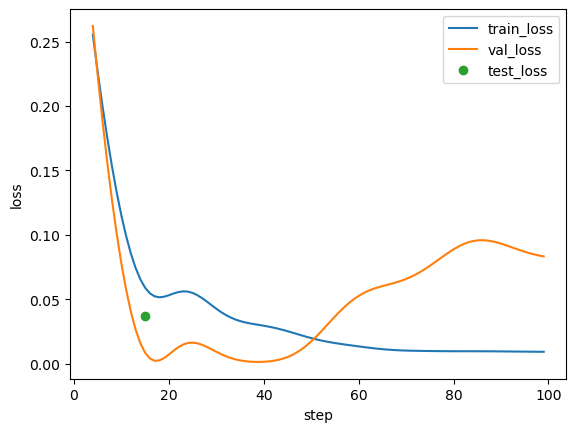

In [23]:
def train_model(model, x, y, batch_size, epochs,seed,split,val_metric):
    from pytorch_lightning import Trainer
    import torch
    from torch.utils.data import DataLoader, TensorDataset
    from pytorch_lightning.callbacks import ModelCheckpoint
    from pytorch_lightning.loggers import CSVLogger
    from pytorch_lightning.callbacks.early_stopping import EarlyStopping
    
    split=list(split)
    if len(split)<3:
        split=split+[0]*(3-len(split))
    split = np.array(split[:3],dtype=float)
    split = split/split.sum()
    split= (split.cumsum()*len(x)).astype(int)


    # split into train test and validation
    rng = np.random.RandomState(seed)
    indices = np.arange(len(x))
    rng.shuffle(indices)
    train_indices = indices[: split[0]]
    test_indices = indices[split[0] : split[1]]
    val_indices = indices[split[1] :]

    x_train = torch.tensor(x[train_indices], dtype=torch.float32)
    y_train = torch.tensor(y[train_indices], dtype=torch.float32)
    x_test = torch.tensor(x[test_indices], dtype=torch.float32)
    y_test = torch.tensor(y[test_indices], dtype=torch.float32)
    x_val = torch.tensor(x[val_indices], dtype=torch.float32)
    y_val = torch.tensor(y[val_indices], dtype=torch.float32)

    train_ds = TensorDataset(x_train, y_train)
    test_ds = TensorDataset(x_test, y_test)
    val_ds = TensorDataset(x_val, y_val)

    train_dl = DataLoader(train_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    checkpoint_callback = ModelCheckpoint(dirpath=modeldir,filename='best_model',monitor=val_metric,enable_version_counter=False)
    modelpath=os.path.join(checkpoint_callback.dirpath,checkpoint_callback.filename+checkpoint_callback.FILE_EXTENSION)
    training_results=YAMLWrapConfig(os.path.join(modeldir,"training_results.yml"))
    
    csv_logger=CSVLogger(modeldir,name="tempdir",version="temp")
    early_stopping_cb=EarlyStopping(monitor=val_metric, min_delta=0.00, patience=200)
    trainer = Trainer(max_epochs=epochs, log_every_n_steps=1,callbacks=[checkpoint_callback,early_stopping_cb],logger=[csv_logger])
    trainer.fit(model, train_dl, val_dl,ckpt_path=modelpath if os.path.exists(modelpath) else None)
    print("PAT",early_stopping_cb.patience)
    training_results["training_epochs"]=trainer.current_epoch


    model = model.__class__.load_from_checkpoint(modelpath,**hyperparameter["model"]["model_hp"])
    
    if os.path.exists(os.path.join(modeldir,"tempdir","temp","metrics.csv")):
        new_metrics = pd.read_csv(os.path.join(modeldir,"tempdir","temp","metrics.csv"))


        if os.path.exists(os.path.join(modeldir,"metrics.csv")):
            old_metrics = pd.read_csv(os.path.join(modeldir,"metrics.csv"))
            new_metrics = pd.concat([old_metrics,new_metrics])

        new_metrics.set_index(['epoch', 'step'], inplace=True)
        new_metrics = new_metrics.groupby(level=['epoch', 'step']).first()
        new_metrics = new_metrics.reset_index()
        new_metrics = new_metrics.dropna(axis=1, how='all')
        new_metrics.to_csv(os.path.join(modeldir,"metrics.csv"),index=False)


        best_score=float(checkpoint_callback.best_model_score.cpu().numpy())
        training_results["best_score"]=best_score
        closest = new_metrics.loc[(new_metrics[val_metric] - best_score).abs().idxmin()]
        training_results["best_epoch"]=int(closest["epoch"])
        training_results["best_step"]=int(closest["step"])
        test_loss = trainer.test(model, test_dl)
        training_results["test_loss"]=list(test_loss[0].values())[0]

        r=20
    
        for c in new_metrics.columns:
            if c in ['epoch', 'step']:
                continue
            nan=new_metrics[c].isna()
            rows=new_metrics[~nan]
            print(len(rows))
            plt.plot(rows['step'],rows[c].rolling(max(1,int(len(rows)/r))).mean(),"-o" if len(rows)<10 else "-" ,label=c)
        plt.plot(training_results["best_step"], training_results["test_loss"],"o",label="test_loss")

       # plt.yscale("log")
        
        plt.legend()
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.savefig(os.path.join(modeldir,"metrics.png"),dpi=300)
        plt.show()
        plt.close()
            
    shutil.rmtree(os.path.join(modeldir,"tempdir"))



train_model(
    model,x,y,
    **hyperparameter["model"]["training"]
)